# Homework 2: Line Detection

## Imports

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

from util import ops
from util.keypoint_detection import HessianDetector

## Load Image Data

In [2]:
original_image = ops.load_image("./original-images/road.png")

Dimensions of ./original-images/road.png: 407 x 548


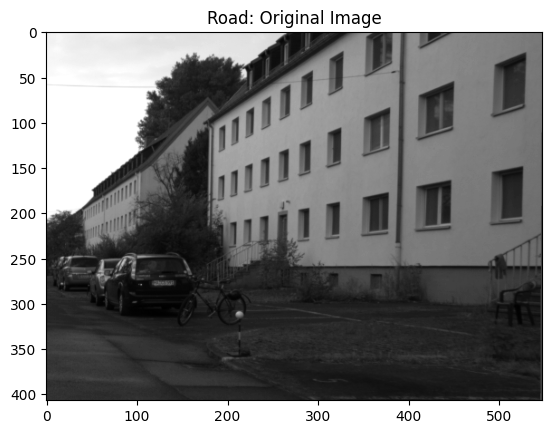

In [3]:
plt.title("Road: Original Image")
plt.imshow(original_image, cmap="gray")
plt.show()

## Problem 1: Preprocessing

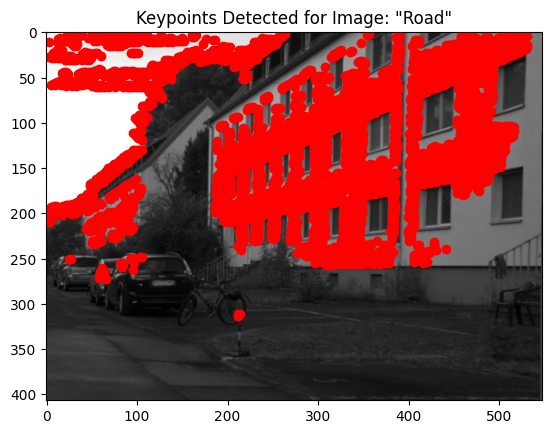

In [4]:
HessianDetector.find_keypoints_and_visualize(
    np.array(original_image), 
    "Road",
    percentile=68.05  # note: I had to run the code several times to arrive at this value
)

## Problem 2: RANSAC

### Core RANSAC Implementation Code

For convenience, let's make it so that we have a NumPy-ified version of the image on hand:

In [3]:
img_array = np.array(original_image)

Let's test out the core RANSAC algorithm implementation:

In [4]:
from util.model_fitting import RANSACDetector

In [5]:
np.random.seed(42)

In [8]:
# test
keypoints = HessianDetector().find_keypoints(
    img_array, percentile=68.05
)

assert keypoints.shape[0] == 2

In [9]:
ransac = RANSACDetector()

In [10]:
top_4_models, num_iterations = ransac.fit(
    keypoints
)

/Users/zainraza/Downloads/dev/courses/Stevens/CS-558/Line-Detection/util/model_fitting.py:84: RuntimeWarning: divide by zero encountered in scalar divide
  m = (point2[0] - point1[0]) / (point2[1] - point1[1])
/Users/zainraza/Downloads/dev/courses/Stevens/CS-558/Line-Detection/util/model_fitting.py:64: RuntimeWarning: invalid value encountered in scalar add
  numerator = abs(a * x_coord + b * y_coord + c)


In [11]:
num_iterations

3590.120646659043

In [12]:
[
    top_4_models[row][0].shape
    for row in range(len(top_4_models))
]

[(200, 2), (175, 2), (165, 2), (146, 2)]

In [13]:
[
    top_4_models[row][0].shape
    for row in range(len(top_4_models))
]

[(200, 2), (175, 2), (165, 2), (146, 2)]

### Visualizing RANSAC Results

In [8]:
import functools

In [9]:
keypoint_detector = HessianDetector()

keypoint_detector_for_road = functools.partial(
    keypoint_detector.find_keypoints, percentile=68.05
)

/Users/zainraza/Downloads/dev/courses/Stevens/CS-558/Line-Detection/util/model_fitting.py:84: RuntimeWarning: divide by zero encountered in scalar divide
  m = (point2[0] - point1[0]) / (point2[1] - point1[1])
/Users/zainraza/Downloads/dev/courses/Stevens/CS-558/Line-Detection/util/model_fitting.py:64: RuntimeWarning: invalid value encountered in scalar add
  numerator = abs(a * x_coord + b * y_coord + c)


=============== Horray! You just ran RANSAC :) ===================
Inlier threshold distance: 3.0, so we can reach a confidence level of approx. 0.95.
Total number of iterations (rounded to the nearest integer): 3590.
Confidence Level used in Calculating No. of Iterations: 0.99.


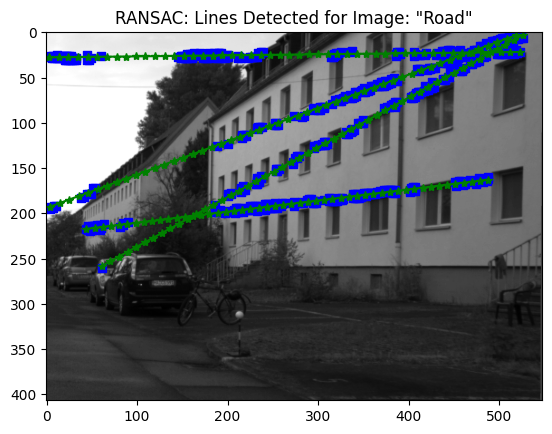

In [10]:
RANSACDetector.fit_and_report(
    image=img_array,
    keypoint_detector_algorithm=keypoint_detector_for_road,
    image_name='Road',
    distance_threshold=3.0,
)

## Problem 3: Hough Transform

Let's start with the same keypoints as before:

In [6]:
# test
keypoints = HessianDetector().find_keypoints(
    img_array, percentile=68.05
)

assert keypoints.shape[0] == 2

In [7]:
keypoint_coords = keypoints.T  # [(y1, x1), (y2, x2), ...]

First Attept: Bad

Accumulator shape: (1365, 180)
Size of input, size of padded: ((1365, 180), (1367, 182))
local_max_accumulator has same shape as accumulator: ((1365, 180), (1365, 180))
local_max_accumulator: [[0. 0. 0. ... 0. 0. 7.]
 [0. 0. 0. ... 0. 0. 0.]
 [4. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 6.]
 [0. 0. 0. ... 0. 0. 0.]]
accumulator: [[0. 0. 0. ... 0. 0. 7.]
 [0. 0. 0. ... 0. 0. 0.]
 [4. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 6.]
 [0. 0. 0. ... 0. 0. 0.]]
detected_lines #: (79293,)


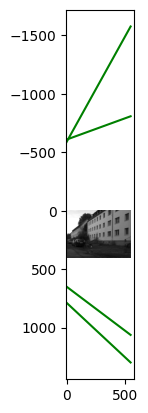

In [8]:
import numpy as np
import matplotlib.pyplot as plt

from util.ops import (
    IDENTITY_FILTER,
    pad as padding_op,
)


### HELPER
# prevent potential loss of keypoints via padding
def _non_max_suppression(matrix):
    keypoints = matrix
    padded_matrix, num_added_rows, num_added_cols = padding_op(
        keypoints.tolist(),
        img_filter=IDENTITY_FILTER,
        stride=1,
        padding_type="zero",
    )
    print(f"Size of input, size of padded: {keypoints.shape, padded_matrix.shape}")
    # traverse the matrix, to begin non-max suppression
    for center_val_row in range(
        num_added_rows // 2, padded_matrix.shape[0] - (num_added_rows // 2)
    ):
        for center_val_col in range(
            num_added_cols // 2, padded_matrix.shape[1] - (num_added_cols // 2)
        ):
            # determine if the given value should be suppressed, or its neighbors
            center_val = padded_matrix[center_val_row][center_val_col]
            neighbors = padded_matrix[
                center_val_row - 1 : center_val_row + 2,
                center_val_col - 1 : center_val_col + 2,
            ]
            neighbors[1][
                1
            ] = 0  # hack to prevent the center value from "self-suppressing" (I have no idea, I made that term up)
            # zero out the appropiate value(s)
            if center_val > neighbors.max():  # suppression of neighbors
                padded_matrix[
                    center_val_row - 1 : center_val_row + 2,
                    center_val_col - 1 : center_val_col + 2,
                ] = 0
                padded_matrix[center_val_row][center_val_col] = center_val
            else:  # suppression of the center
                padded_matrix[center_val_row][center_val_col] = 0

    # return the modified matrix - TODO[optimize later]
    return padded_matrix[
        num_added_rows // 2 : padded_matrix.shape[0] - (num_added_rows // 2),
        num_added_cols // 2 : padded_matrix.shape[1] - (num_added_cols // 2),
    ]

### DRIVER
# Define the parameter space for the Hough transform
max_rho = np.hypot(img_array.shape[0], img_array.shape[1])

# Reduced resolutions for rho and theta
rho_resolution = 1
theta_resolution = np.pi / 180

# Calculate the new size of the accumulator array
rho_bins = int(2 * max_rho / rho_resolution)
theta_bins = int(np.pi / theta_resolution)

# Create the accumulator array with the new size
accumulator = np.zeros((rho_bins, theta_bins))
print(f"Accumulator shape: {accumulator.shape}")

# Voting in the accumulator array
for point in keypoint_coords:
    for theta in np.arange(0, np.pi, theta_resolution):
        col = x_coord = point[1]
        row = y_coord = point[0]
        rho = int(x_coord * np.cos(theta) + y_coord * np.sin(theta))
        rho_bin = int(rho / rho_resolution)
        theta_bin = int(theta / theta_resolution)
        accumulator[rho_bin, theta_bin] += 1

# Thresholding to identify detected lines 
#   --> use non max suppression
local_max_accumulator = _non_max_suppression(accumulator)
print(f"local_max_accumulator has same shape as accumulator: {local_max_accumulator.shape, accumulator.shape}")
print(f"local_max_accumulator: {local_max_accumulator}")
#   --> return an array of size [2, 4] - the first col is the rho index, second is the theta index
# threshold = 50  # Adjust as needed
threshold = 0
detected_lines = np.where(accumulator > threshold)
# print(f"detected_lines shape: {detected_lines.shape}")
print(f"accumulator: {local_max_accumulator}")
print(f"detected_lines #: {detected_lines[0].shape}")

# Extract and convert a sampling of detected lines to Cartesian coordinates
sample_indices = np.random.choice(
    range(detected_lines[0].shape[0]),
    size=4, replace=False  # TODO[don't use a magic number here]
)
detected_rho = (detected_lines[0][sample_indices] * rho_resolution) - max_rho
detected_theta = detected_lines[1][sample_indices] * theta_resolution

# Plot the image and detected lines
# plt.subplot(121)
plt.imshow(img_array, cmap='gray')

for rho, theta in zip(detected_rho, detected_theta):
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    # find two coords on the line, to use for plotting
    # x1 = int(x0 + 1000 * (-b))
    # y1 = int(y0 + 1000 * (a))
    # x2 = int(x0 - 1000 * (-b))
    # y2 = int(y0 - 1000 * (a))
    # ...
    x_values = np.array([0, img_array.shape[1]])
    y_values = (rho - (a * x_values)) / b
    plt.plot(x_values, y_values, color='green')

# # Plot the accumulator array as a 2D histogram
# plt.subplot(122)
# plt.imshow(local_max_accumulator, cmap='gray')
# plt.title('Hough Transform Accumulator')
# plt.xlabel('Theta (radians)')
# plt.ylabel('Rho (pixels)')

plt.show()


Accumulator shape: (1365, 180)
Size of input, size of padded: ((1365, 180), (1367, 182))
local_max_accumulator has same shape as accumulator: ((1365, 180), (1365, 180))
local_max_accumulator: [[0. 0. 0. ... 0. 0. 7.]
 [0. 0. 0. ... 0. 0. 0.]
 [4. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 6.]
 [0. 0. 0. ... 0. 0. 0.]]
accumulator: [[0. 0. 0. ... 0. 0. 7.]
 [0. 0. 0. ... 0. 0. 0.]
 [4. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 6.]
 [0. 0. 0. ... 0. 0. 0.]]
detected_lines #: ((76,), (76,))
sample_indices: [26 43 52 57]


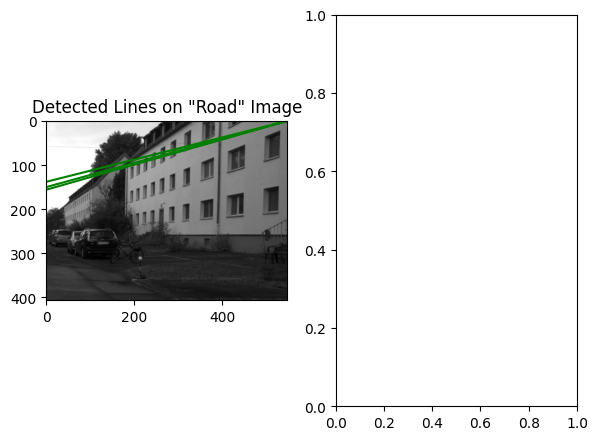

In [30]:
import numpy as np
import matplotlib.pyplot as plt

from util.ops import (
    IDENTITY_FILTER,
    pad as padding_op,
)


### HELPER
# prevent potential loss of keypoints via padding
def _non_max_suppression(matrix):
    keypoints = matrix
    padded_matrix, num_added_rows, num_added_cols = padding_op(
        keypoints.tolist(),
        img_filter=IDENTITY_FILTER,
        stride=1,
        padding_type="zero",
    )
    print(f"Size of input, size of padded: {keypoints.shape, padded_matrix.shape}")
    # traverse the matrix, to begin non-max suppression
    for center_val_row in range(
        num_added_rows // 2, padded_matrix.shape[0] - (num_added_rows // 2)
    ):
        for center_val_col in range(
            num_added_cols // 2, padded_matrix.shape[1] - (num_added_cols // 2)
        ):
            # determine if the given value should be suppressed, or its neighbors
            center_val = padded_matrix[center_val_row][center_val_col]
            neighbors = padded_matrix[
                center_val_row - 1 : center_val_row + 2,
                center_val_col - 1 : center_val_col + 2,
            ]
            neighbors[1][
                1
            ] = 0  # hack to prevent the center value from "self-suppressing" (I have no idea, I made that term up)
            # zero out the appropiate value(s)
            if center_val > neighbors.max():  # suppression of neighbors
                padded_matrix[
                    center_val_row - 1 : center_val_row + 2,
                    center_val_col - 1 : center_val_col + 2,
                ] = 0
                padded_matrix[center_val_row][center_val_col] = center_val
            else:  # suppression of the center
                padded_matrix[center_val_row][center_val_col] = 0

    # return the modified matrix - TODO[optimize later]
    return padded_matrix[
        num_added_rows // 2 : padded_matrix.shape[0] - (num_added_rows // 2),
        num_added_cols // 2 : padded_matrix.shape[1] - (num_added_cols // 2),
    ]

### DRIVER
# Define the parameter space for the Hough transform
max_rho = np.hypot(img_array.shape[0], img_array.shape[1])

# Reduced resolutions for rho and theta
rho_resolution = 1
theta_resolution = np.pi / 180

# Calculate the new size of the accumulator array
rho_bins = int(2 * max_rho / rho_resolution)
theta_bins = int(np.pi / theta_resolution)

# Create the accumulator array with the new size
accumulator = np.zeros((rho_bins, theta_bins))
print(f"Accumulator shape: {accumulator.shape}")

# Voting in the accumulator array
for point in keypoint_coords:
    for theta in np.arange(0, np.pi, theta_resolution):
        col = x_coord = point[1]
        row = y_coord = point[0]
        rho = int(x_coord * np.cos(theta) + y_coord * np.sin(theta))
        rho_bin = int(rho / rho_resolution)
        theta_bin = int(theta / theta_resolution)
        accumulator[rho_bin, theta_bin] += 1

# Thresholding to identify detected lines 
#   --> use non max suppression
local_max_accumulator = _non_max_suppression(accumulator)
print(f"local_max_accumulator has same shape as accumulator: {local_max_accumulator.shape, accumulator.shape}")
print(f"local_max_accumulator: {local_max_accumulator}")
#   --> return an array of size [2, 4] - the first col is the rho index, second is the theta index
# threshold = 50  # Adjust as needed
threshold = 55
detected_lines = np.where(accumulator > threshold)
# print(f"detected_lines shape: {detected_lines.shape}")
print(f"accumulator: {local_max_accumulator}")
print(f"detected_lines #: {detected_lines[0].shape, detected_lines[1].shape}")

# Extract and convert a sampling of detected lines to Cartesian coordinates
sample_indices = np.random.choice(
    range(detected_lines[0].shape[0]),
    size=4, replace=False  # TODO[don't use a magic number here]
)

print(f"sample_indices: {sample_indices}")
detected_rho = (detected_lines[0][sample_indices] * rho_resolution) - max_rho
detected_theta = detected_lines[1][sample_indices] * theta_resolution

# Plot the image and detected lines
# plt.subplot(121)
# plt.imshow(img_array, cmap='gray')

# Create a figure with matching dimensions to the input image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(img_array.shape[1] / 80, img_array.shape[0] / 80))

# Plot the image and detected lines
for rho, theta in zip(detected_rho, detected_theta):
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    x1 = int(x0 + 1000 * (-b))
    y1 = int(y0 + 1000 * (a))
    x2 = int(x0 - 1000 * (-b))
    y2 = int(y0 - 1000 * (a))

    # Ensure endpoints are within image bounds
    x1 = max(0, min(x1, img_array.shape[1] - 1))
    y1 = max(0, min(y1, img_array.shape[0] - 1))
    x2 = max(0, min(x2, img_array.shape[1] - 1))
    y2 = max(0, min(y2, img_array.shape[0] - 1))

    ax1.plot([x1, x2], [y1, y2], color='green')
image_name = "Road"  # TODO[set as a param]
ax1.set_title(f"Detected Lines on \"{image_name}\" Image")
ax1.imshow(img_array, cmap='gray')  # plot the image in the background

# # Plot the accumulator array as a 2D histogram
# plt.subplot(122)
# plt.imshow(accumulator, cmap='gray', extent=[0, np.pi, -max_rho, max_rho])
# plt.title('Hough Transform Accumulator')
# plt.xlabel('Theta (radians)')
# plt.ylabel('Rho (pixels)')

# plt.show()


Accumulator shape: (1365, 180)
Size of input, size of padded: ((1365, 180), (1367, 182))
local_max_accumulator has same shape as accumulator: ((1365, 180), (1365, 180))
local_max_accumulator: [[0. 0. 0. ... 0. 0. 7.]
 [0. 0. 0. ... 0. 0. 0.]
 [4. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 6.]
 [0. 0. 0. ... 0. 0. 0.]]
accumulator: [[0. 0. 0. ... 0. 0. 7.]
 [0. 0. 0. ... 0. 0. 0.]
 [4. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 6.]
 [0. 0. 0. ... 0. 0. 0.]]
detected_lines #: ((170,), (170,))
sample_indices: [101 168 102 135]


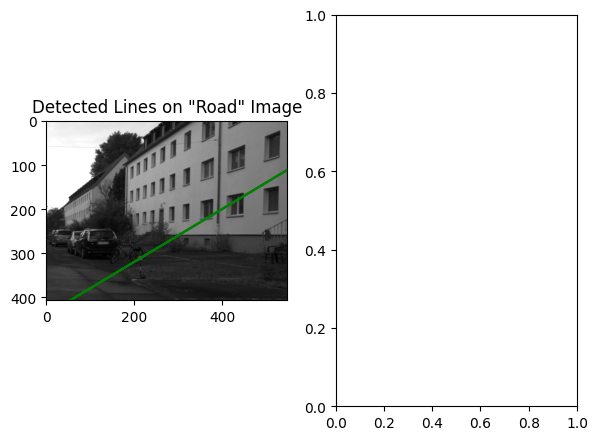

In [10]:
import numpy as np
import matplotlib.pyplot as plt

from util.ops import (
    IDENTITY_FILTER,
    pad as padding_op,
)


### HELPER
# prevent potential loss of keypoints via padding
def _non_max_suppression(matrix):
    keypoints = matrix
    padded_matrix, num_added_rows, num_added_cols = padding_op(
        keypoints.tolist(),
        img_filter=IDENTITY_FILTER,
        stride=1,
        padding_type="zero",
    )
    print(f"Size of input, size of padded: {keypoints.shape, padded_matrix.shape}")
    # traverse the matrix, to begin non-max suppression
    for center_val_row in range(
        num_added_rows // 2, padded_matrix.shape[0] - (num_added_rows // 2)
    ):
        for center_val_col in range(
            num_added_cols // 2, padded_matrix.shape[1] - (num_added_cols // 2)
        ):
            # determine if the given value should be suppressed, or its neighbors
            center_val = padded_matrix[center_val_row][center_val_col]
            neighbors = padded_matrix[
                center_val_row - 1 : center_val_row + 2,
                center_val_col - 1 : center_val_col + 2,
            ]
            neighbors[1][
                1
            ] = 0  # hack to prevent the center value from "self-suppressing" (I have no idea, I made that term up)
            # zero out the appropiate value(s)
            if center_val > neighbors.max():  # suppression of neighbors
                padded_matrix[
                    center_val_row - 1 : center_val_row + 2,
                    center_val_col - 1 : center_val_col + 2,
                ] = 0
                padded_matrix[center_val_row][center_val_col] = center_val
            else:  # suppression of the center
                padded_matrix[center_val_row][center_val_col] = 0

    # return the modified matrix - TODO[optimize later]
    return padded_matrix[
        num_added_rows // 2 : padded_matrix.shape[0] - (num_added_rows // 2),
        num_added_cols // 2 : padded_matrix.shape[1] - (num_added_cols // 2),
    ]

### DRIVER
# Define the parameter space for the Hough transform
max_rho = np.hypot(img_array.shape[0], img_array.shape[1])

# Reduced resolutions for rho and theta
rho_resolution = 1
theta_resolution = np.pi / 180

# Calculate the new size of the accumulator array
rho_bins = int(2 * max_rho / rho_resolution)
theta_bins = int(np.pi / theta_resolution)

# Create the accumulator array with the new size
accumulator = np.zeros((rho_bins, theta_bins))
print(f"Accumulator shape: {accumulator.shape}")

# Voting in the accumulator array
for point in keypoint_coords:
    for theta in np.arange(0, np.pi, theta_resolution):
        col = x_coord = point[1]
        row = y_coord = point[0]
        rho = int(x_coord * np.cos(theta) + y_coord * np.sin(theta))
        rho_bin = int(rho / rho_resolution)
        theta_bin = int(theta / theta_resolution)
        accumulator[rho_bin, theta_bin] += 1

# Thresholding to identify detected lines 
#   --> use non max suppression
local_max_accumulator = _non_max_suppression(accumulator)
print(f"local_max_accumulator has same shape as accumulator: {local_max_accumulator.shape, accumulator.shape}")
print(f"local_max_accumulator: {local_max_accumulator}")
#   --> return an array of size [2, 4] - the first col is the rho index, second is the theta index
# threshold = 50  # Adjust as needed
threshold = 50
detected_lines = np.where(accumulator > threshold)
# print(f"detected_lines shape: {detected_lines.shape}")
print(f"accumulator: {local_max_accumulator}")
print(f"detected_lines #: {detected_lines[0].shape, detected_lines[1].shape}")

# Extract and convert a sampling of detected lines to Cartesian coordinates
sample_indices = np.random.choice(
    range(detected_lines[0].shape[0]),
    size=4, replace=False  # TODO[don't use a magic number here]
)

print(f"sample_indices: {sample_indices}")
detected_rho = (detected_lines[0][sample_indices] * rho_resolution) - max_rho
detected_theta = detected_lines[1][sample_indices] * theta_resolution

# Plot the image and detected lines
# plt.subplot(121)
# plt.imshow(img_array, cmap='gray')

# Create a figure with matching dimensions to the input image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(img_array.shape[1] / 80, img_array.shape[0] / 80))

# Plot the image and detected lines
for rho_bin, theta_bin in zip(detected_lines[0][sample_indices], detected_lines[1][sample_indices]):
    theta = theta_bin * theta_resolution
    rho = rho_bin * rho_resolution
    rho = int(x_coord * np.cos(theta) + y_coord * np.sin(theta))
    x_intercept = (rho - (0 * np.sin(theta))) / (np.cos(theta))
    y_intercept = (rho - (0 * np.cos(theta))) / (np.sin(theta))


    # Ensure endpoints are within image bounds
    # x1 = max(0, min(x1, img_array.shape[1] - 1))
    # y1 = max(0, min(y1, img_array.shape[0] - 1))
    # x2 = max(0, min(x2, img_array.shape[1] - 1))
    # y2 = max(0, min(y2, img_array.shape[0] - 1))

    ax1.plot([x_intercept, 0], [0, y_intercept], color='green')
image_name = "Road"  # TODO[set as a param]
ax1.set_title(f"Detected Lines on \"{image_name}\" Image")
ax1.imshow(img_array, cmap='gray')  # plot the image in the background

# # Plot the accumulator array as a 2D histogram
# plt.subplot(122)
# plt.imshow(accumulator, cmap='gray', extent=[0, np.pi, -max_rho, max_rho])
# plt.title('Hough Transform Accumulator')
# plt.xlabel('Theta (radians)')
# plt.ylabel('Rho (pixels)')

# plt.show()


Accumulator shape: (1365, 180)
Size of input, size of padded: ((1365, 180), (1367, 182))
local_max_accumulator has same shape as accumulator: ((1365, 180), (1365, 180))
local_max_accumulator: [[0. 0. 0. ... 0. 0. 7.]
 [0. 0. 0. ... 0. 0. 0.]
 [4. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 6.]
 [0. 0. 0. ... 0. 0. 0.]]
least_to_greatest_votes shape: (4,)
sample_indices: 4


Text(0, 0.5, 'Rho (pixels)')

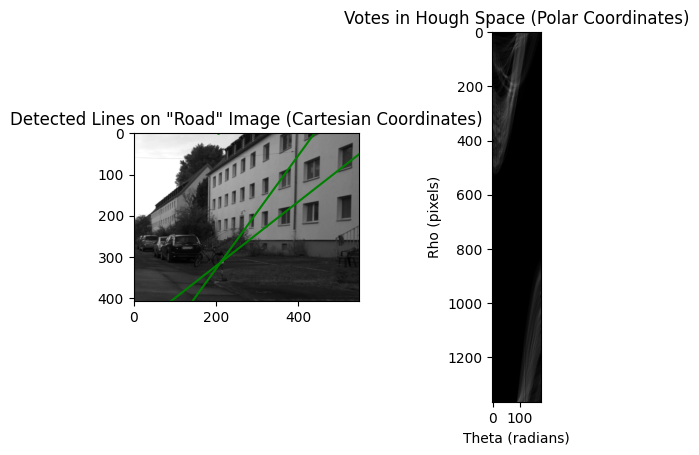

In [29]:
import numpy as np
import matplotlib.pyplot as plt

from util.ops import (
    IDENTITY_FILTER,
    pad as padding_op,
)


### HELPER
# prevent potential loss of keypoints via padding
def _non_max_suppression(matrix):
    keypoints = matrix
    padded_matrix, num_added_rows, num_added_cols = padding_op(
        keypoints.tolist(),
        img_filter=IDENTITY_FILTER,
        stride=1,
        padding_type="zero",
    )
    print(f"Size of input, size of padded: {keypoints.shape, padded_matrix.shape}")
    # traverse the matrix, to begin non-max suppression
    for center_val_row in range(
        num_added_rows // 2, padded_matrix.shape[0] - (num_added_rows // 2)
    ):
        for center_val_col in range(
            num_added_cols // 2, padded_matrix.shape[1] - (num_added_cols // 2)
        ):
            # determine if the given value should be suppressed, or its neighbors
            center_val = padded_matrix[center_val_row][center_val_col]
            neighbors = padded_matrix[
                center_val_row - 1 : center_val_row + 2,
                center_val_col - 1 : center_val_col + 2,
            ]
            neighbors[1][
                1
            ] = 0  # hack to prevent the center value from "self-suppressing" (I have no idea, I made that term up)
            # zero out the appropiate value(s)
            if center_val > neighbors.max():  # suppression of neighbors
                padded_matrix[
                    center_val_row - 1 : center_val_row + 2,
                    center_val_col - 1 : center_val_col + 2,
                ] = 0
                padded_matrix[center_val_row][center_val_col] = center_val
            else:  # suppression of the center
                padded_matrix[center_val_row][center_val_col] = 0

    # return the modified matrix - TODO[optimize later]
    return padded_matrix[
        num_added_rows // 2 : padded_matrix.shape[0] - (num_added_rows // 2),
        num_added_cols // 2 : padded_matrix.shape[1] - (num_added_cols // 2),
    ]

### DRIVER
# Define the parameter space for the Hough transform
max_rho = np.hypot(img_array.shape[0], img_array.shape[1])

# Reduced resolutions for rho and theta
rho_resolution = 1
theta_resolution = np.pi / 180

# Calculate the new size of the accumulator array
rho_bins = int(2 * max_rho / rho_resolution)
theta_bins = int(np.pi / theta_resolution)

# Create the accumulator array with the new size
accumulator = np.zeros((rho_bins, theta_bins))
print(f"Accumulator shape: {accumulator.shape}")

# Voting in the accumulator array
for point in keypoint_coords:
    for theta in np.arange(0, np.pi, theta_resolution):
        col = x_coord = point[1]
        row = y_coord = point[0]
        rho = int(x_coord * np.cos(theta) + y_coord * np.sin(theta))
        rho_bin = int(rho / rho_resolution)
        theta_bin = int(theta / theta_resolution)
        accumulator[rho_bin, theta_bin] += 1

# Thresholding to identify detected lines 
#   --> use non max suppression
local_max_accumulator = _non_max_suppression(accumulator)
print(f"local_max_accumulator has same shape as accumulator: {local_max_accumulator.shape, accumulator.shape}")
print(f"local_max_accumulator: {local_max_accumulator}")
#   --> return an array of size [2, 4] - the first col is the rho index, second is the theta index
# threshold = 50  # Adjust as needed
# threshold = 50
# detected_lines = np.where(accumulator > threshold)
# # print(f"detected_lines shape: {detected_lines.shape}")
# print(f"accumulator: {local_max_accumulator}")
# print(f"detected_lines #: {detected_lines[0].shape, detected_lines[1].shape}")

# # Extract and convert a sampling of detected lines to Cartesian coordinates

# sample_indices = np.random.choice(
#     range(detected_lines[0].shape[0]),
#     size=4, replace=False  # TODO[don't use a magic number here]
# )

local_max_accumulator_flat = local_max_accumulator.reshape(1, -1)
least_to_greatest_votes = np.argsort(local_max_accumulator_flat)[0, -4:]
print(f"least_to_greatest_votes shape: {least_to_greatest_votes.shape}")
sample_indices = [
    (
        flat_index // local_max_accumulator.shape[0], 
        ((flat_index // local_max_accumulator.shape[1]) % local_max_accumulator.shape[1]) - 1
    )
    for flat_index in least_to_greatest_votes
]


print(f"sample_indices: {len(sample_indices)}")
# detected_rho = (detected_lines[0][sample_indices] * rho_resolution) - max_rho
# detected_theta = detected_lines[1][sample_indices] * theta_resolution

# Plot the image and detected lines
# plt.subplot(121)
# plt.imshow(img_array, cmap='gray')

# Create a figure with matching dimensions to the input image
fig, (ax1, ax2) = plt.subplots(1, 2)

# Plot the image and detected lines
for rho_bin, theta_bin in sample_indices:
    theta = theta_bin * theta_resolution
    rho = rho_bin * rho_resolution
    rho = int(x_coord * np.cos(theta) + y_coord * np.sin(theta))
    x_intercept = (rho - (0 * np.sin(theta))) / (np.cos(theta))
    y_intercept = (rho - (0 * np.cos(theta))) / (np.sin(theta))

    ax1.plot([x_intercept, 0], [0, y_intercept], color='green')
image_name = "Road"  # TODO[set as a param]
ax1.set_title(f"Detected Lines on \"{image_name}\" Image (Cartesian Coordinates)")
ax1.imshow(img_array, cmap='gray')  # plot the image in the background

# Plot the accumulator array as a 2D histogram
# plt.subplot(122)
accumulator_in_pixel_scale = (
    (accumulator - accumulator.min()) / 
    (accumulator.max() - accumulator.min())
) * 255.

ax2.imshow(accumulator_in_pixel_scale, cmap='gray')
ax2.set_title('Votes in Hough Space (Polar Coordinates)')
ax2.set_xlabel('Theta (radians)')
ax2.set_ylabel('Rho (pixels)')

# ax2.show()
